In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [4]:
df = pd.read_csv("823rows.csv")
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'EVENT_ID', 'EVENT_NAME',
       'EVENT_START_DATETIME', 'EVENT_END_DATETIME', 'CLASSIFICATION_GENRE',
       'CLASSIFICATION_SUB_GENRE', 'MIN_PRICE', 'MAX_PRICE', 'ATTRACTION_NAME',
       'ATTRACTION_ID', 'VENUE_NAME', 'VENUE_ID', 'VENUE_STREET', 'VENUE_CITY',
       'VENUE_STATE_CODE', 'VENUE_TIMEZONE', 'CLASSIFICATION_TYPE',
       'CLASSIFICATION_SUB_TYPE', 'ATTRACTION_CLASSIFICATION_SEGMENT',
       'ATTRACTION_CLASSIFICATION_GENRE',
       'ATTRACTION_CLASSIFICATION_SUB_GENRE', 'ATTRACTION_CLASSIFICATION_TYPE',
       'ATTRACTION_CLASSIFICATION_SUB_TYPE', 'TRANSACTABLE', 'HOT_EVENT',
       'scrape_time', 'city', 'city_ascii', 'state_id', 'state_name',
       'population', 'CAPACITY', 'individual_artist', 'id', 'name',
       'artist_popularity', 'artist_genres', 'followers', 'genre_0', 'genre_1',
       'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6', 'lower_name'],
      dtype='object')

add columns with time in useful format

In [5]:
df["EVENT_START_DATETIME"] = pd.to_datetime(df["EVENT_START_DATETIME"])
event_start = pd.to_datetime(df["EVENT_START_DATETIME"]).astype(np.int64) // 10**9
scrape_time = pd.to_datetime(df["scrape_time"]).astype(np.int64) // 10**9
df["time_to_concert"] =  event_start - scrape_time

localized_times = df.apply(lambda row: row['EVENT_START_DATETIME'].tz_convert(row['VENUE_TIMEZONE']), axis=1)

def get_day_of_week(dt):
    return dt.weekday()
df["day_of_week"] = localized_times.map(get_day_of_week)

def get_hour(dt):
    return dt.hour
df["hour_of_day"] = localized_times.map(get_hour)

keep only columns that could help with predicting price

In [6]:
to_keep = [
    "CLASSIFICATION_GENRE",
    "CLASSIFICATION_SUB_GENRE",
    "MIN_PRICE", 
    "MAX_PRICE",
    "HOT_EVENT",
    "CAPACITY",
    "population",
    "time_to_concert",
    "artist_popularity",
    "VENUE_STATE_CODE",
    "TRANSACTABLE",
    "day_of_week",
    "hour_of_day"
]
df = df[to_keep]

removing null values

In [7]:
# print number of null values in each column
for col in df.columns:
    print(col, "has", df[col].isna().sum(), "null values")

CLASSIFICATION_GENRE has 0 null values
CLASSIFICATION_SUB_GENRE has 4 null values
MIN_PRICE has 0 null values
MAX_PRICE has 0 null values
HOT_EVENT has 0 null values
CAPACITY has 175 null values
population has 44 null values
time_to_concert has 0 null values
artist_popularity has 0 null values
VENUE_STATE_CODE has 0 null values
TRANSACTABLE has 109 null values
day_of_week has 0 null values
hour_of_day has 0 null values


In [8]:
df["CLASSIFICATION_SUB_GENRE"] = df['CLASSIFICATION_SUB_GENRE'].fillna(df['CLASSIFICATION_GENRE'])
df.dropna(inplace=True)

In [9]:
categorical_cols = [col_name for col_name in df.columns if df[col_name].dtype == "object"]
X = pd.get_dummies(df.drop(["MIN_PRICE", "MAX_PRICE"], axis=1), columns=categorical_cols)

In [10]:
min_y = df['MIN_PRICE']  
max_y = df["MAX_PRICE"]

In [11]:
def train_and_evalute(x, y, model):
    ''' 
    x: dataframe
    y: series
    model: some object with a .fit() and .predict() method
    returns: performance
    '''
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {
        "mse": mse,
        "r2": r2,
        "model": model
    }

# Linear Regression

## min price

In [12]:
train_and_evalute(X, min_y, LinearRegression())

{'mse': 645.1694430827711,
 'r2': 0.20949774196561766,
 'model': LinearRegression()}

## max price

In [13]:
train_and_evalute(X, max_y, LinearRegression())

{'mse': 7529.230833281524,
 'r2': 0.500582662983933,
 'model': LinearRegression()}

# random forest

## min price

In [14]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(n_estimators=100, random_state=100), param_grid, cv=5, scoring="r2")
grid_search.fit(X, min_y)
print(grid_search.best_params_)
grid_search.best_score_

{'max_depth': 30, 'min_samples_split': 10}


0.38846898044534256

## max price

In [15]:
rand_for_max = train_and_evalute(X, max_y, RandomForestRegressor(n_estimators=500, random_state=100))
rand_for_max

{'mse': 3974.134622867091,
 'r2': 0.7363938263756744,
 'model': RandomForestRegressor(n_estimators=500, random_state=100)}

# KNN

before doing knn, all values should be normalized so that large values do not influence the results

In [16]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(X)

## min price

In [17]:
param_grid = {
    "n_neighbors": [i for i in range(3, int(scaled_x.shape[0]**0.5) + 2, 2)]  # square root of number of samples is a recommended value
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring="r2")
grid_search.fit(scaled_x, min_y)
print(grid_search.best_params_)
grid_search.best_score_

{'n_neighbors': 11}


0.2184945502220689

## max price

In [18]:
param_grid = {
    "n_neighbors": [i for i in range(3, int(scaled_x.shape[0]**0.5) + 2, 2)]  # square root of number of samples is a recommended value
}  # and number of neighbors should be odd

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring="r2")
grid_search.fit(scaled_x, max_y)
print(grid_search.best_params_)
grid_search.best_score_

{'n_neighbors': 5}


0.4395297620193667

# visualization of best model

The best model appears to be the random forest regressor predicting maximum price, with a r^2 of 0.736

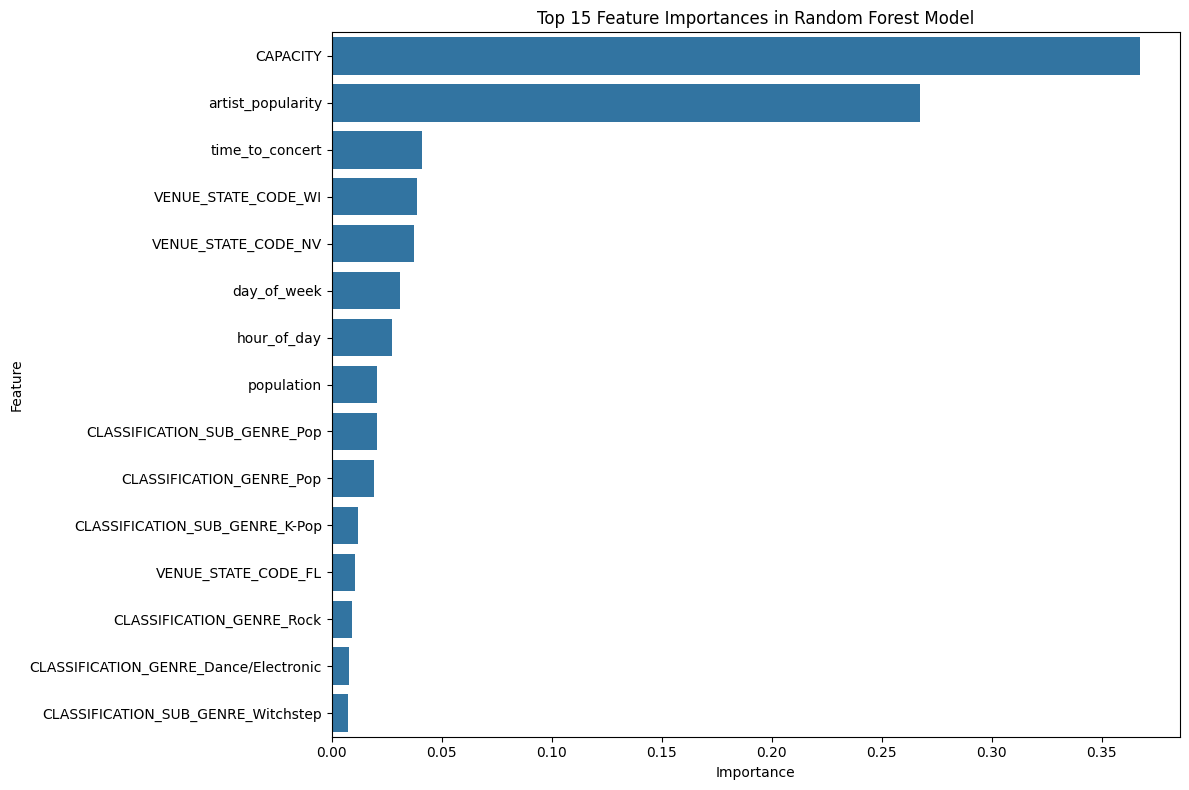

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the Random Forest model
feature_importances = rand_for_max["model"].feature_importances_
features = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 15 Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


(array([344.,  80.,  46.,  37.,  13.,   7.,   4.,   2.,   0.,   1.]),
 array([ 15.  , 107.95, 200.9 , 293.85, 386.8 , 479.75, 572.7 , 665.65,
        758.6 , 851.55, 944.5 ]),
 <BarContainer object of 10 artists>)

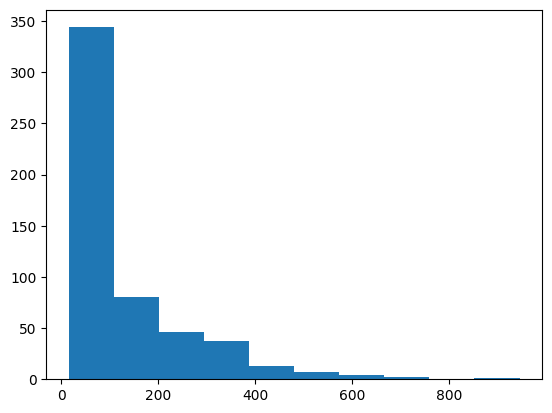

In [20]:
plt.hist(max_y)

The histogram shows how there are some concerts with extreme outlier prices, which likely contributes to the high MSE of the random forest model, even though it has a high r^2 value.